## Portfolio Optimization 

### (1) Importing libraries 

In [29]:
import yfinance as yf
import pandas as pd 
from datetime import datetime, timedelta
import numpy as np 
from scipy.optimize import minimize
import matplotlib.pyplot as plt


### Tickers and time

In [2]:
tickers = ["SPY","BND","GLD","QQQ","VTI"]

In [3]:
end_date = datetime.today()
# Just start date 5 years from current date
start_date = end_date - timedelta(days = 5*365)

### (2) Creating the Dataframe and getting adjusted close price 

In [4]:
adj_close_df = pd.DataFrame()

In [5]:
# Downloading the close price for each ticker
for ticker in tickers:
    data = yf.download(tickers=ticker,start = start_date, end=end_date)
    adj_close_df[ticker] = data["Adj Close"]  

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [6]:
print(adj_close_df)

                   SPY        BND         GLD         QQQ         VTI
Date                                                                 
2019-10-16  276.226959  73.508522  140.410004  187.111832  140.278671
2019-10-17  277.041534  73.508522  140.610001  187.606171  140.741058
2019-10-18  275.828949  73.543495  140.460007  185.803329  140.176941
2019-10-21  277.698883  73.368683  139.789993  187.451065  141.092468
2019-10-22  276.791656  73.499771  140.199997  185.958389  140.667068
...                ...        ...         ...         ...         ...
2024-10-07  567.799988  73.930000  244.169998  482.100006  280.170013
2024-10-08  573.169983  74.040001  242.369995  489.299988  282.529999
2024-10-09  577.140015  73.839996  241.050003  493.149994  284.500000
2024-10-10  576.130005  73.809998  242.820007  492.589996  283.910004
2024-10-11  579.580017  73.820000  245.470001  493.359985  286.109985

[1256 rows x 5 columns]


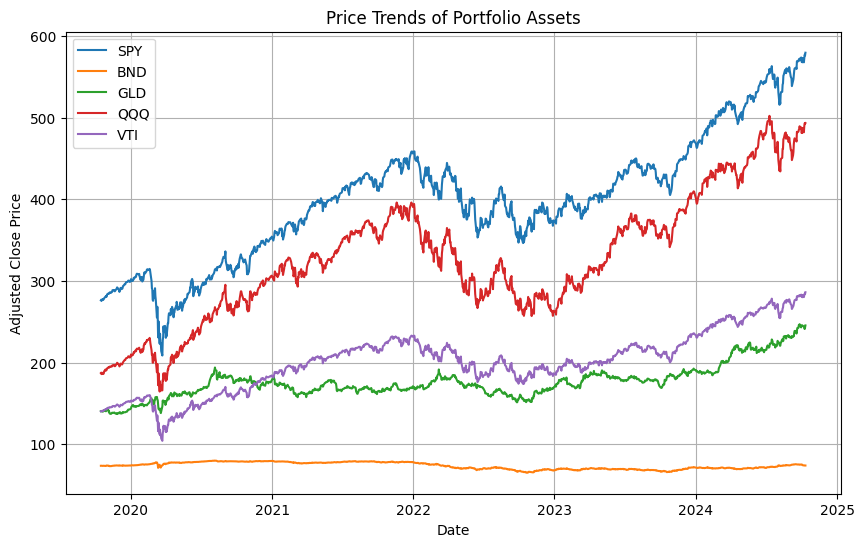

In [30]:
# Price Trends and Normalized Prices
# Price Trends Plot
plt.figure(figsize=(10, 6))
for ticker in tickers:
    plt.plot(adj_close_df[ticker], label=ticker)
plt.title('Price Trends of Portfolio Assets')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

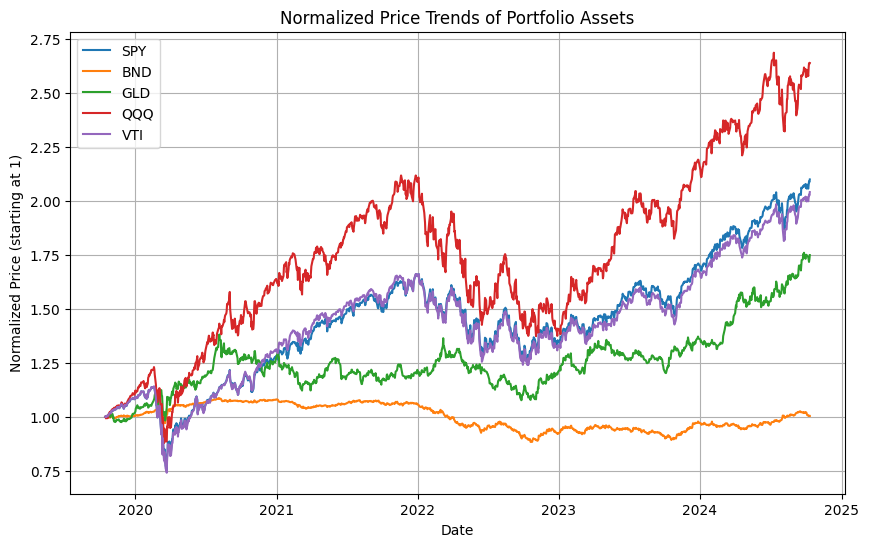

In [31]:
# Normalized Price Plot (all prices start at 1 for comparison)
normalized_prices = adj_close_df / adj_close_df.iloc[0]
plt.figure(figsize=(10, 6))
for ticker in tickers:
    plt.plot(normalized_prices[ticker], label=ticker)
plt.title('Normalized Price Trends of Portfolio Assets')
plt.xlabel('Date')
plt.ylabel('Normalized Price (starting at 1)')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

### (3) Calculating Lognormal returns Daily Returns

In [8]:
log_returns = np.log(adj_close_df/adj_close_df.shift(1))

In [27]:
# dropping missing values 
log_returns = log_returns.dropna()
print(log_returns)

                 SPY       BND       GLD       QQQ       VTI
Date                                                        
2019-10-17  0.002945  0.000000  0.001423  0.002638  0.003291
2019-10-18 -0.004387  0.000476 -0.001067 -0.009656 -0.004016
2019-10-21  0.006756 -0.002380 -0.004782  0.008829  0.006510
2019-10-22 -0.003272  0.001785  0.002929 -0.007995 -0.003020
2019-10-23  0.002906  0.000476  0.002351  0.001927  0.002036
...              ...       ...       ...       ...       ...
2024-10-07 -0.009082 -0.002971 -0.003394 -0.010769 -0.009167
2024-10-08  0.009413  0.001487 -0.007399  0.014824  0.008388
2024-10-09  0.006903 -0.002705 -0.005461  0.007838  0.006949
2024-10-10 -0.001752 -0.000406  0.007316 -0.001136 -0.002076
2024-10-11  0.005970  0.000136  0.010854  0.001562  0.007719

[1255 rows x 5 columns]


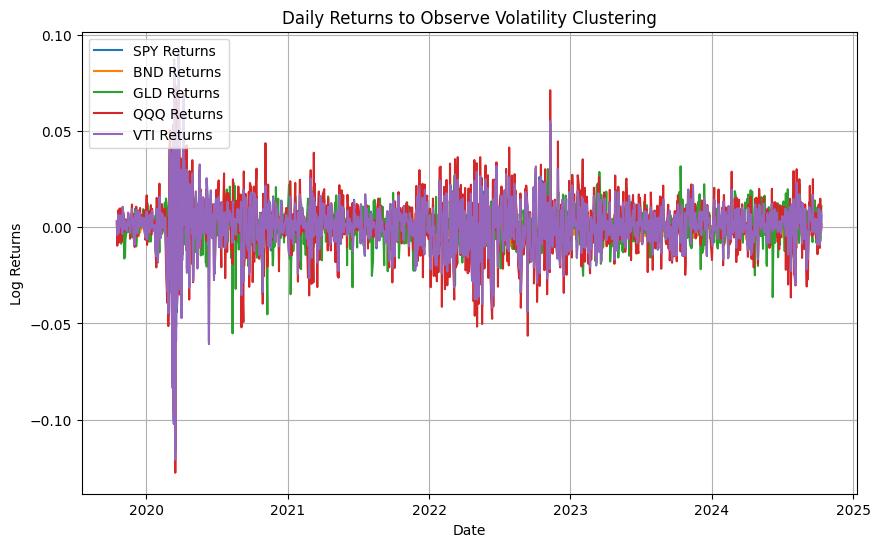

In [32]:
# Returns to Observe Volatility Clustering
plt.figure(figsize=(10, 6))
for ticker in tickers:
    plt.plot(log_returns[ticker], label=f'{ticker} Returns')
plt.title('Daily Returns to Observe Volatility Clustering')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

### (4) Calcuating the Covariance Matrix

In [10]:
cov_matrix = log_returns.cov() * 252
print(cov_matrix)

          SPY       BND       GLD       QQQ       VTI
SPY  0.043998  0.003087  0.004944  0.049902  0.045083
BND  0.003087  0.004874  0.003780  0.003709  0.003283
GLD  0.004944  0.003780  0.023279  0.006476  0.005188
QQQ  0.049902  0.003709  0.006476  0.065324  0.051047
VTI  0.045083  0.003283  0.005188  0.051047  0.046575


### (5) Portfolio Perfomance metrics

#### Calculating Standard Deviation of the Portfolio

In [12]:
def standard_deviation(weights, cov_matrix):
    variance = weights.T@cov_matrix@weights
    return np.sqrt(variance)

#### Calculating expected return 

In [13]:
def expected_return(weights, log_returns): 
    return np.sum(log_returns.mean() * weights) * 252

#### Calculating the Sharpe Ratio

In [18]:
def sharpe_ratio(weights, log_returns,cov_matrix,risk_free_rate) :
    return (expected_return(weights,log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

### (6) Portfolio Optimization

#### Getting Risk Free Rate using the FED API 

In [17]:
from fredapi import Fred
fred = Fred(api_key = "d12e3b12f0540f09d785e8908b2d9aa9")
ten_year_treasury = fred.get_series_latest_release("GS10")/ 100

# setting the risk free rate 
risk_free_rate = ten_year_treasury.iloc[-1]
print(risk_free_rate)

0.037200000000000004


#### Minimizing the negative sharpe ratio

##### We minimize the -ve sharpe in order to 'MAXIMIZE the function' goal for a portfolio is a high sharpe ratio


In [19]:
def neg_sharpe_ratio(weights,log_returns,cov_matrix,risk_free_rate):
    return -sharpe_ratio(weights,log_returns,cov_matrix,risk_free_rate)

#### Next is setting up our constraints

##### Constraints are conditions that must be met during optimization, in this case the sum of all portfolio weights must be equal to 1. Bounds are limits placed.

In [20]:
constraints = {"type":"eq", "fun":lambda weights:np.sum(weights)-1}
bounds = [(0,0.5) for _ in range(len(tickers))]
# setting 0 as lower bound we can't short and 0.5 is we cannot have more than 50% weighting on an individual asset

#### Setting the initial weights

In [21]:
inital_weights = np.array([1/len(tickers)]*len(tickers))
print(inital_weights)

[0.2 0.2 0.2 0.2 0.2]


#### Optimize the weights to maximize the Sharpe Ratio

In [23]:
optimized_results = minimize(neg_sharpe_ratio,inital_weights,args=(log_returns,cov_matrix,risk_free_rate), 
                             method="SLSQP",constraints=constraints,bounds=bounds)
#SLSQP is Sequential Least Squares Quadratic Programing, numerical optimization suitable for non-linear optimization problems

#### Getting Optimal weights

In [24]:
optimal_weights = optimized_results.x

#### Displaying the Portfolio analystics 

In [25]:
print("Optimal weights")
for ticker,weight in zip(tickers,optimal_weights):
    print(f"{ticker}:{weight:.4f}")
print()

optimal_portfolio_return = expected_return(optimal_weights,log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights,cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights,log_returns,cov_matrix,risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal weights
SPY:0.0000
BND:0.0000
GLD:0.5000
QQQ:0.5000
VTI:0.0000

Expected Annual Return: 0.1534
Expected Volatility: 0.1593
Sharpe Ratio: 0.7294


### Final Plot

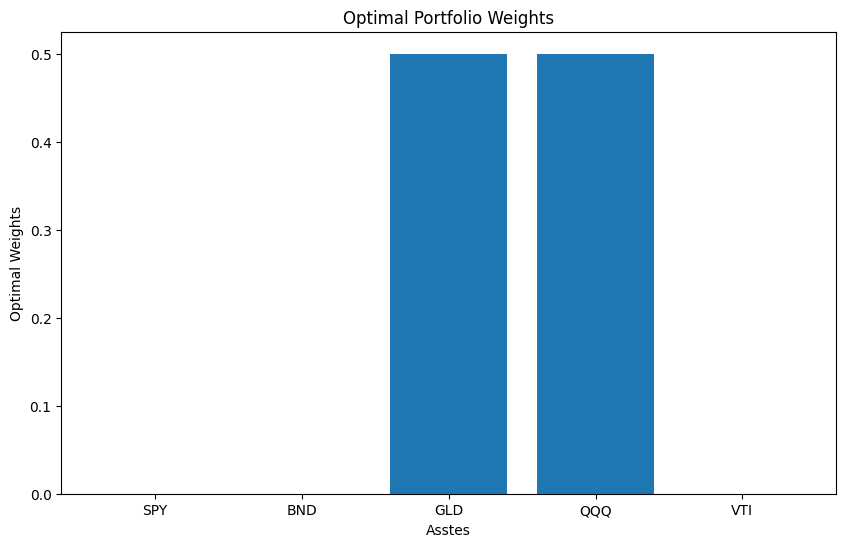

In [26]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(10,6))
plt.bar(tickers,optimal_weights)

plt.xlabel("Asstes")
plt.ylabel("Optimal Weights")
plt.title("Optimal Portfolio Weights")

plt.show()

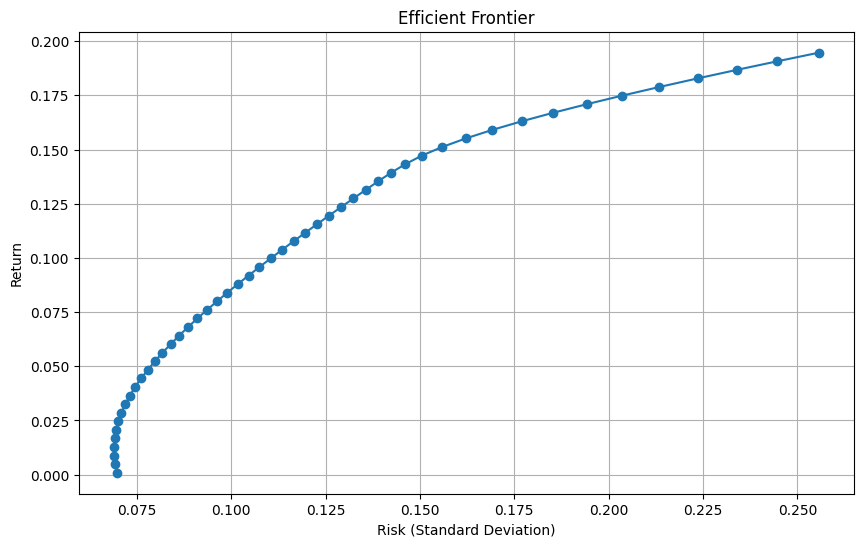

In [33]:
def portfolio_risk(weights, cov_matrix):
    return np.sqrt(weights.T @ cov_matrix @ weights)

def portfolio_return(weights, mean_returns):
    return np.sum(mean_returns * weights)

mean_returns = log_returns.mean() * 252  # Annualized mean returns
cov_matrix = log_returns.cov() * 252  # Annualized covariance matrix

target_returns = np.linspace(mean_returns.min(), mean_returns.max(), 50)
efficient_portfolios = []

for target_return in target_returns:
    constraints = (
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  # Weights sum to 1
        {'type': 'eq', 'fun': lambda weights: portfolio_return(weights, mean_returns) - target_return}  # Return target
    )
    bounds = [(0, 1) for _ in range(len(tickers))]
    result = minimize(portfolio_risk, inital_weights, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)
    efficient_portfolios.append((portfolio_risk(result.x, cov_matrix), target_return))

efficient_portfolios_df = pd.DataFrame(efficient_portfolios, columns=['Risk', 'Return'])

plt.figure(figsize=(10, 6))
plt.plot(efficient_portfolios_df['Risk'], efficient_portfolios_df['Return'], marker='o')
plt.title('Efficient Frontier')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return')
plt.grid(True)
plt.show()